# Uncovering Malicious Apps Through User Feedback: A Machine Learning Approach

## Importing Librabies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Text Processing
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing, Modeling, & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve, auc, 
                             precision_recall_curve, f1_score)
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Advanced Models & Tools
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud

# Warnings and NLTK setup
import nltk
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading

In [2]:
# Load the datasets
apps_data_path = './dataset/googleplaystore.csv'
reviews_data_path = './dataset/googleplaystore_user_reviews.csv'

# Read data
apps_df = pd.read_csv(apps_data_path)
reviews_df = pd.read_csv(reviews_data_path)

# Display basic dataset info
print("Apps Data Overview:")
print(apps_df.info())
print("\nReviews Data Overview:")
print(reviews_df.info())

Apps Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB
None

Reviews Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64295 entries, 0 to 64294
Data columns (total 5 columns):
 #   C

## Exploratory Data Analysis (EDA)

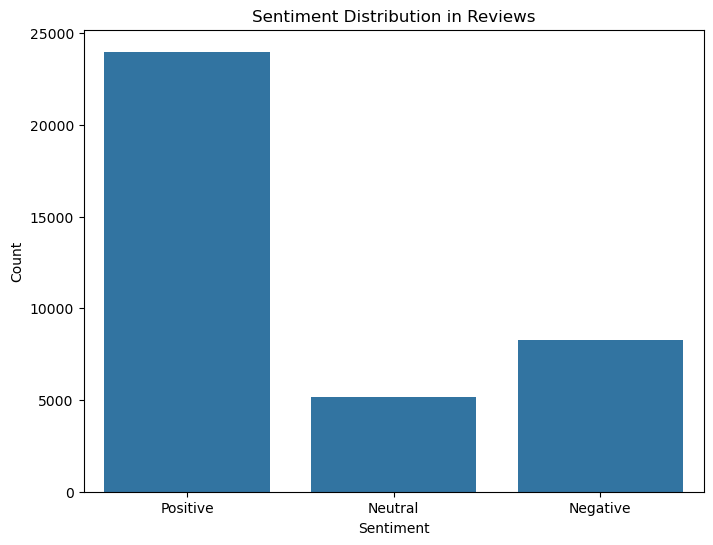

In [3]:
# Sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=reviews_df)
plt.title("Sentiment Distribution in Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

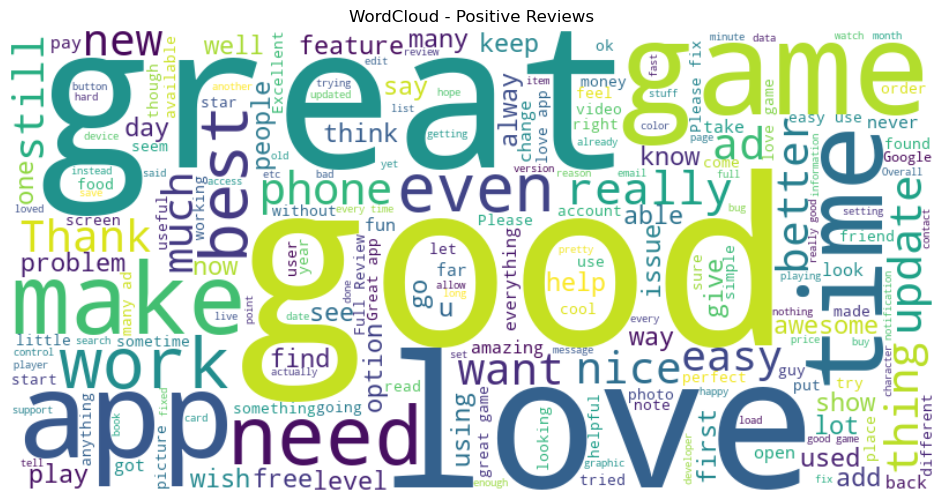

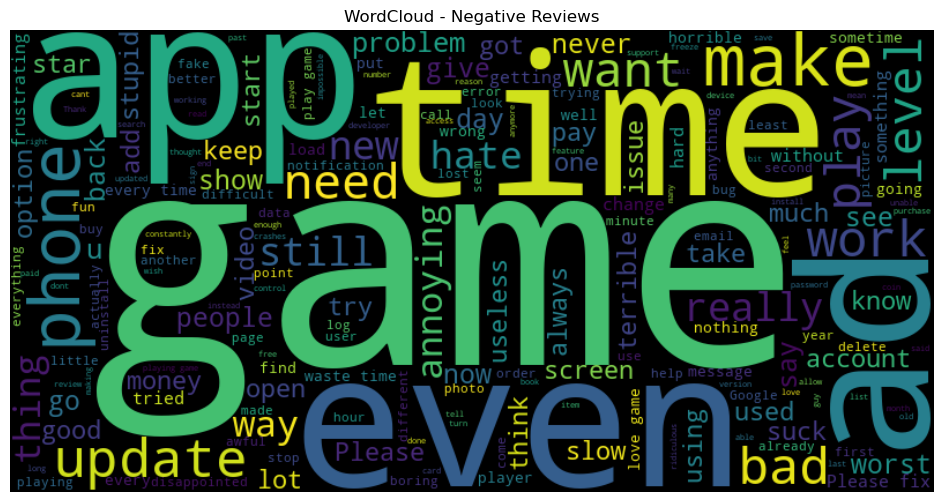

In [4]:
# WordClouds for Positive and Negative Reviews
positive_reviews = " ".join(reviews_df[reviews_df['Sentiment'] == 'Positive']['Translated_Review'].dropna())
negative_reviews = " ".join(reviews_df[reviews_df['Sentiment'] == 'Negative']['Translated_Review'].dropna())

plt.figure(figsize=(12, 6))
wc_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Positive Reviews")
plt.show()

plt.figure(figsize=(12, 6))
wc_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud - Negative Reviews")
plt.show()

## Data Preprocessing

### Apps Data Cleaning

In [5]:
# Drop rows with missing critical features
apps_df.dropna(subset=['Rating', 'Type', 'Content Rating'], inplace=True)

# Clean and convert numeric columns
apps_df['Installs'] = apps_df['Installs'].str.replace('[,+]', '', regex=True).astype(int)
apps_df['Price'] = apps_df['Price'].str.replace('$', '', regex=False).astype(float)
apps_df['Reviews'] = apps_df['Reviews'].astype(int)

### Reviews Data Cleaning

In [6]:
# Keep only rows with non-null reviews and sentiment
reviews_df = reviews_df[reviews_df['Translated_Review'].notna()]
reviews_df.dropna(subset=['Sentiment'], inplace=True)

## Feature Engineering

### Aggregating Reviews

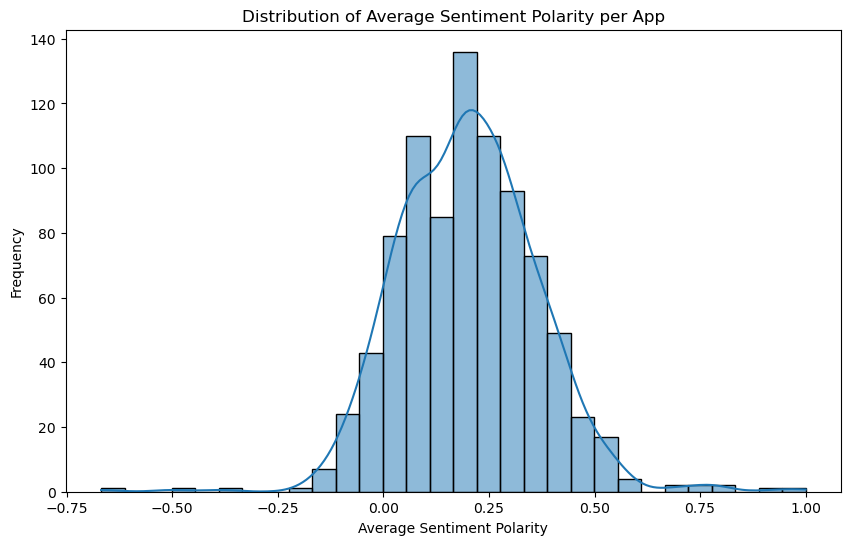

In [7]:
# Aggregate review-level features per app
aggregated_reviews = reviews_df.groupby('App').agg({
    'Sentiment_Polarity': ['mean', 'std'],
    'Sentiment_Subjectivity': ['mean', 'std'],
    'Translated_Review': 'count'
}).reset_index()

# Flatten column names
aggregated_reviews.columns = ['App', 'Polarity_Mean', 'Polarity_STD', 
                              'Subjectivity_Mean', 'Subjectivity_STD', 'Review_Count']

# Visualize the distribution of average sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(aggregated_reviews['Polarity_Mean'], kde=True, bins=30)
plt.title("Distribution of Average Sentiment Polarity per App")
plt.xlabel("Average Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()

## Merging Data

### Apps with Review Aggregates

In [8]:
apps_df = apps_df.merge(aggregated_reviews, on='App', how='left')
# Fill missing aggregated review values (for apps with no reviews) with 0
apps_df[['Polarity_Mean', 'Polarity_STD', 'Subjectivity_Mean', 'Subjectivity_STD', 'Review_Count']] = \
    apps_df[['Polarity_Mean', 'Polarity_STD', 'Subjectivity_Mean', 'Subjectivity_STD', 'Review_Count']].fillna(0)

## Data Transformation & Encoding

In [9]:
# One-hot encode categorical columns for apps
apps_df = pd.get_dummies(apps_df, columns=['Category', 'Type', 'Content Rating'], drop_first=True)

# Bin app ratings into two classes:
# Here, ratings below 3.0 are considered 'Malicious' and ratings 3.0 and above are 'Safe'
bins = [0, 3.0, 5.0]
labels = ['Malicious', 'Safe']
apps_df['Rating_Class'] = pd.cut(apps_df['Rating'], bins=bins, labels=labels, include_lowest=True)
apps_df = apps_df.dropna(subset=['Rating_Class'])

# Prepare features (drop irrelevant columns for modeling)
X = apps_df.drop(['Rating', 'Rating_Class', 'App', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1)
y = apps_df['Rating_Class']

# Convert any remaining object type columns using Label Encoding
for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Standardize features for better model performance, especially for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Additional Visualizations

### Feature Correlation Heatmap

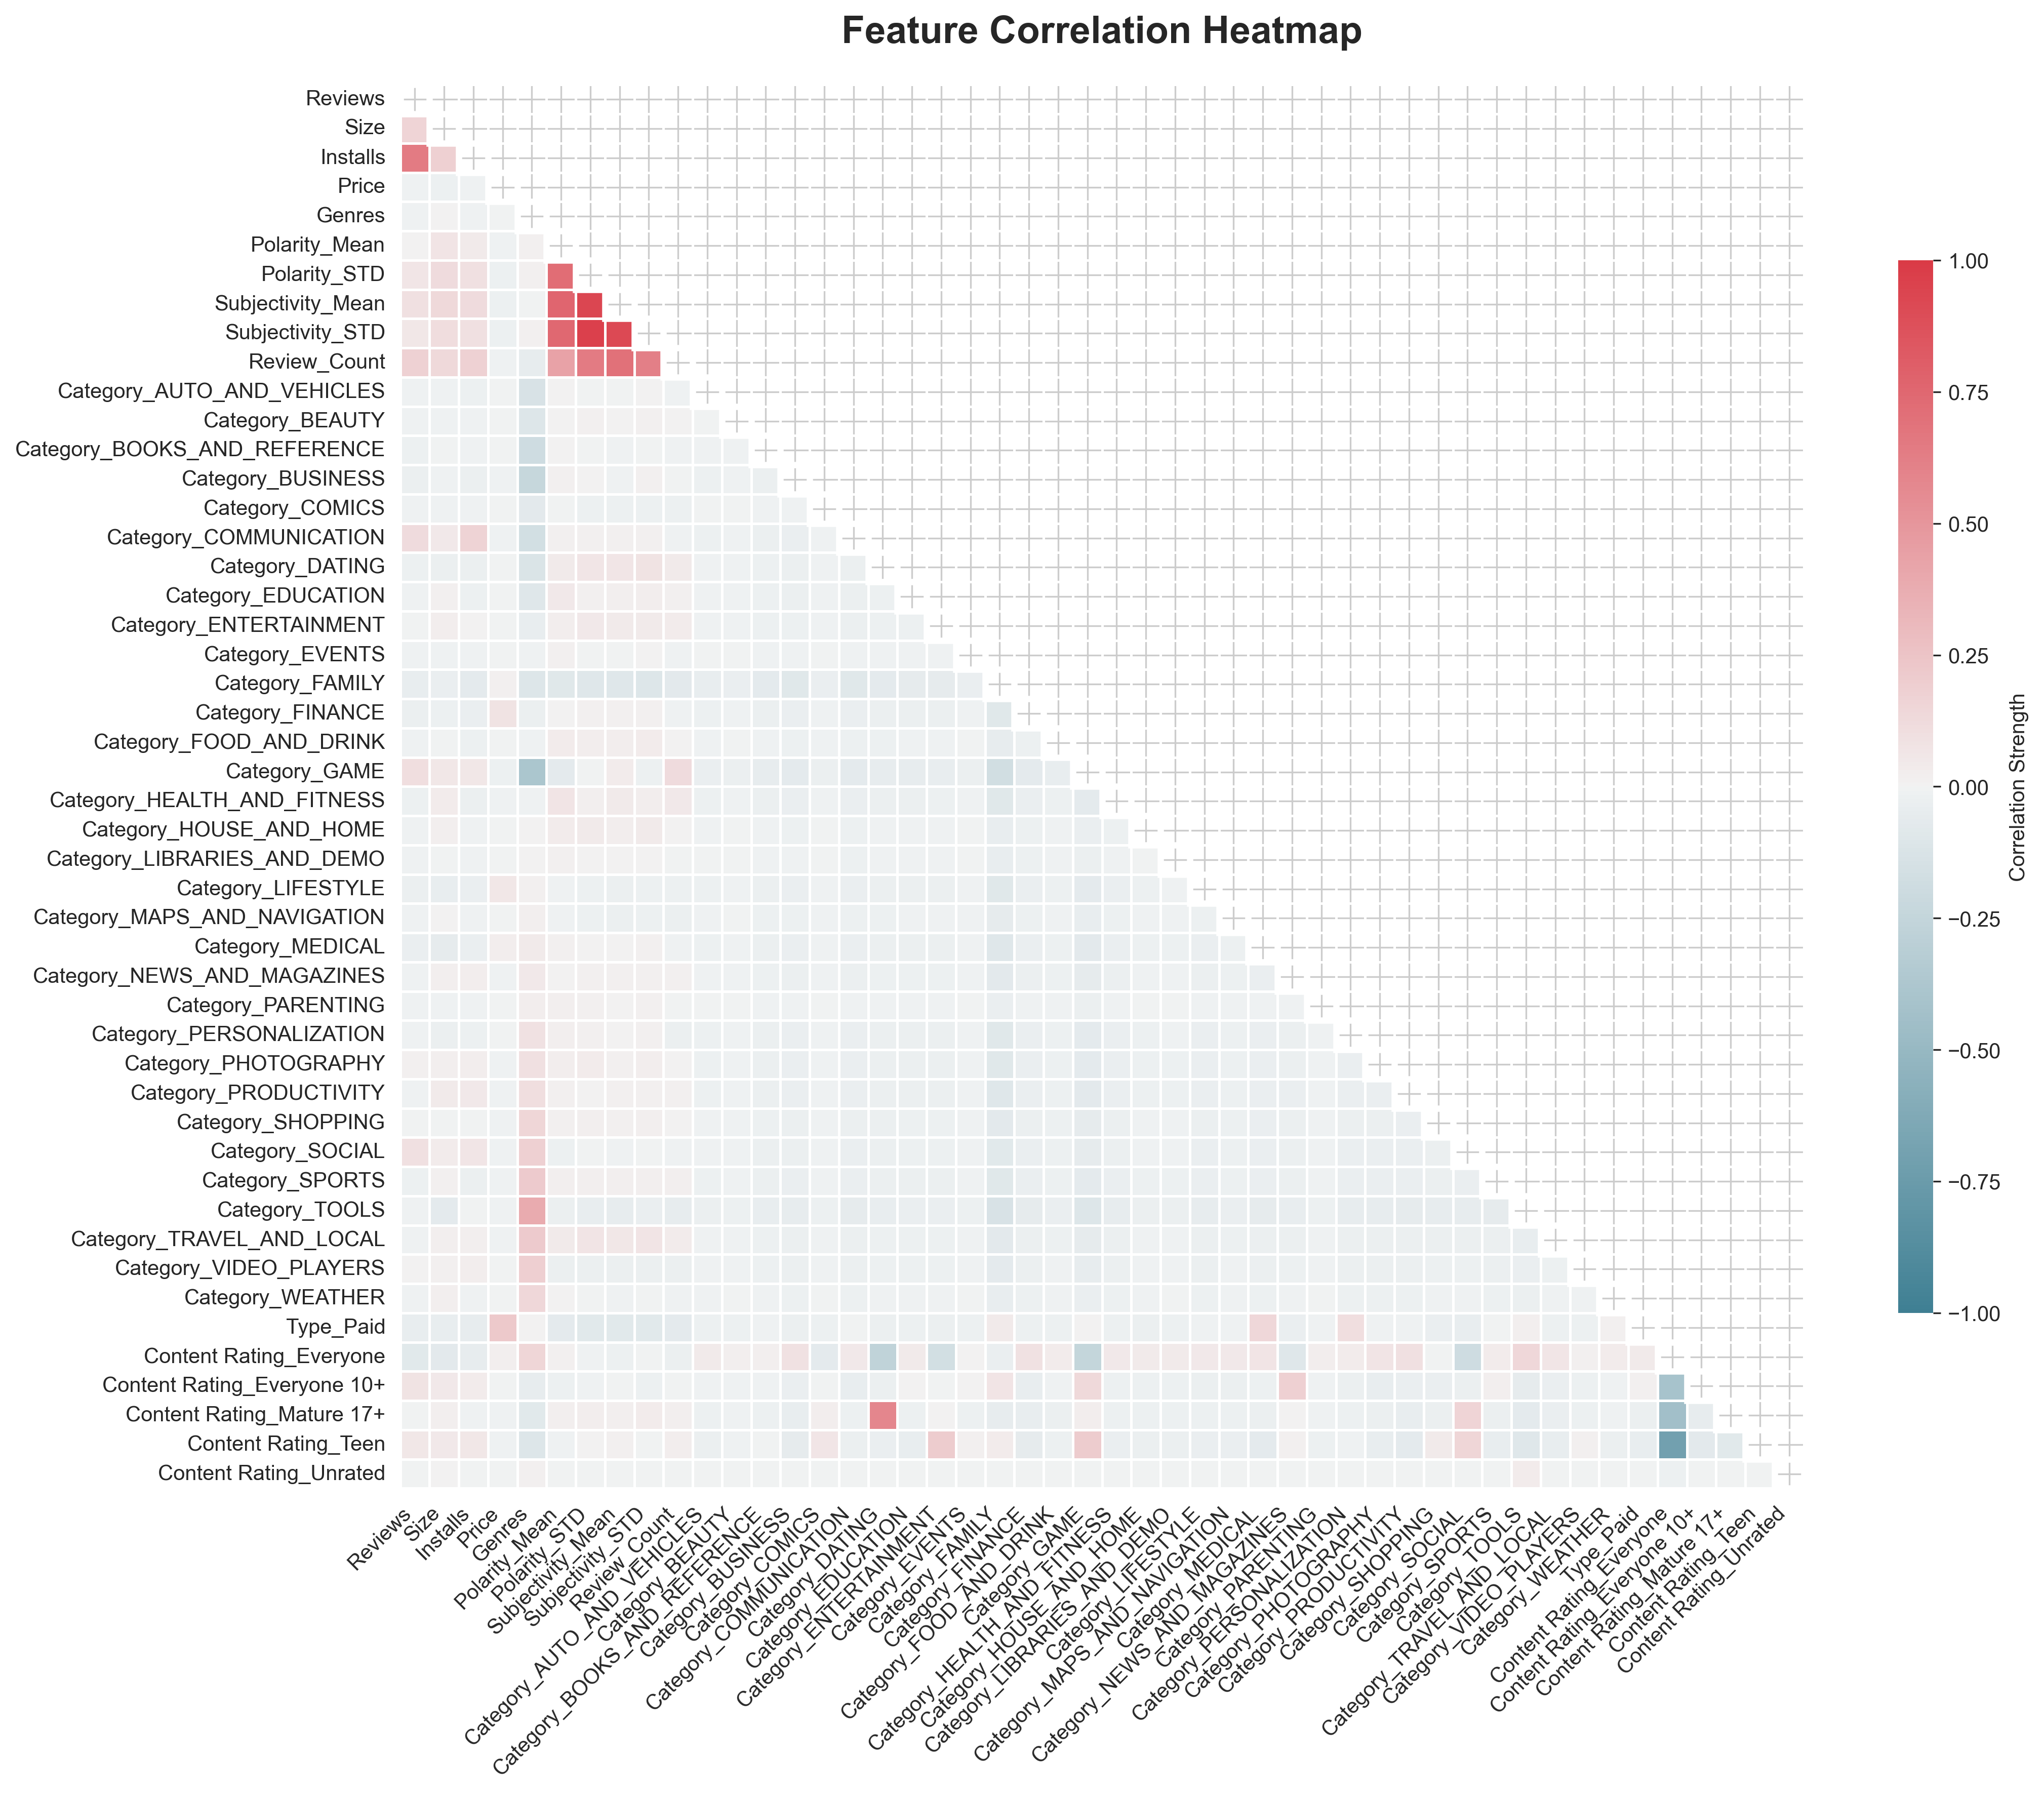

In [10]:
# Compute the correlation matrix of the scaled features
corr_matrix = pd.DataFrame(X_scaled, columns=X.columns).corr()

# Set up the figure size and style for better visualization
plt.figure(figsize=(16, 12), dpi=300)  # High resolution and larger figure size
sns.set_style("whitegrid")  # Use a white grid background for better contrast

# Generate a mask for the upper triangle of the correlation matrix
# This removes redundant information (since correlation matrices are symmetric)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Define a custom colormap using Seaborn's diverging palette
cmap = sns.diverging_palette(220, 10, as_cmap=True)  # Blue to red palette

# Create the heatmap with improved styling
ax = sns.heatmap(
    corr_matrix, 
    mask=mask,  # Apply the mask to hide the upper triangle
    cmap=cmap,  # Use the custom colormap
    annot=False,  # Do not show correlation values in cells (optional: set to True if needed)
    fmt=".2f",  # Format for annotations (if annot=True)
    linewidths=0.8,  # Add space between cells for better readability
    vmin=-1, vmax=1,  # Set the scale for correlation values (-1 to 1)
    cbar_kws={"shrink": 0.75, "aspect": 30, "label": "Correlation Strength"},  # Customize the color bar
    square=True  # Ensure cells are square-shaped
)

# Improve the title and axis labels
plt.title("Feature Correlation Heatmap", fontsize=18, fontweight="bold", pad=20)  # Add a title
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=10)  # Set y-axis label font size

# Add a bold white diagonal line for clarity
for i in range(len(corr_matrix.columns)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=3))

# Display the plot
plt.show()

### PCA Explained Variance

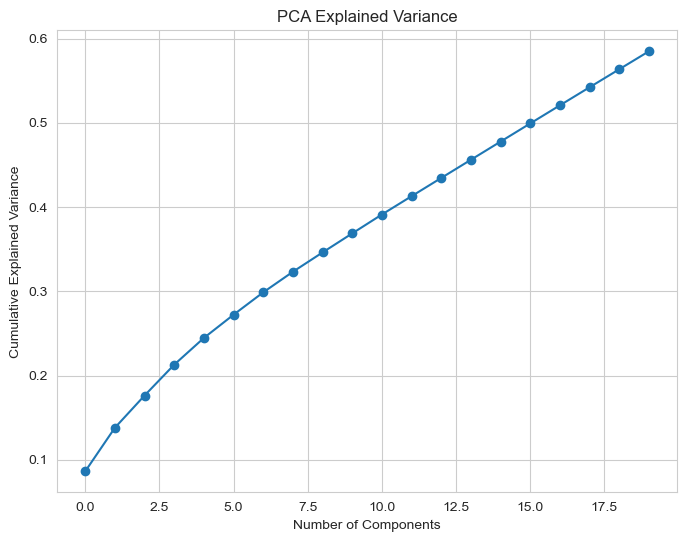

In [11]:
# PCA Explained Variance Plot (to assess dimensionality reduction possibility)
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

## Data Augmentation

Class distribution after SMOTE:
Rating_Class
Malicious    8996
Safe         8996
Name: count, dtype: int64


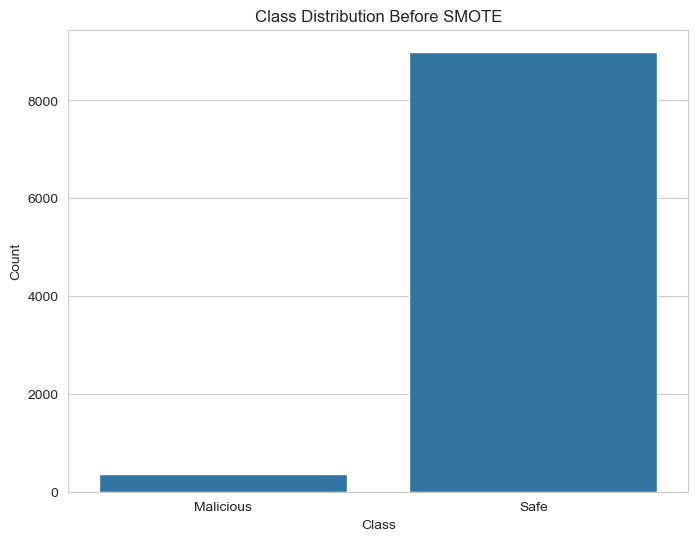

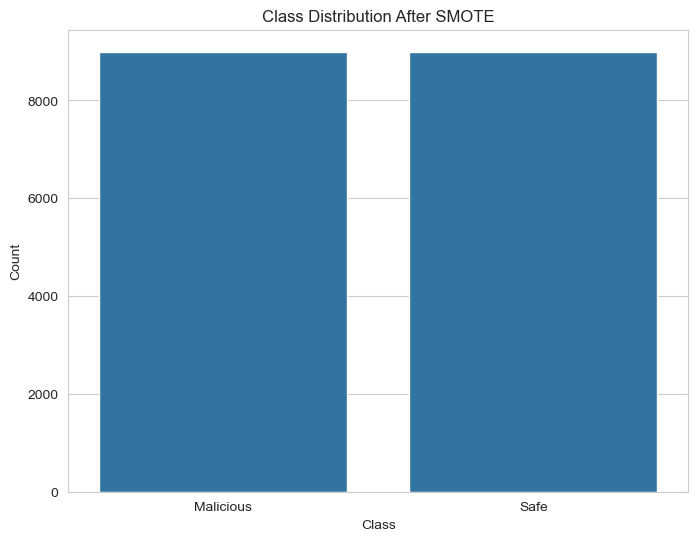

In [12]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Visualize class distribution before and after SMOTE
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Data Splitting

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## Model Architecture & Training

In [14]:
# Initialize base models with tuned hyperparameters to reduce overfitting
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')
svm_model = SVC(probability=True, kernel='rbf', random_state=42, class_weight='balanced', C=1.0)
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, 
                              use_label_encoder=False, eval_metric='logloss')

# Create an ensemble model using soft voting
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('svm', svm_model), ('xgb', xgb_model)],
    voting='soft'
)

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     random_state=42)),
                             ('svm',
                              SVC(class_weight='balanced', probability=True,
                                  random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=N...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

## Threshold Adjustment & Evaluation

In [15]:
# Get predicted probabilities for the positive class (assume label '1' corresponds to "Safe")
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Encode test labels (binary: 0 for one class, 1 for the other)
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)  # For consistency, e.g., 'Malicious': 0, 'Safe': 1

# Optimize threshold based on weighted F1 score
thresholds = np.linspace(0.3, 0.7, 100)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob_ensemble >= thresh).astype(int)
    f1 = f1_score(y_test_encoded, y_pred_thresh, average='weighted')
    f1_scores.append(f1)

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal threshold based on weighted F1: {optimal_threshold:.2f}")

# Apply the new threshold to get adjusted predictions
y_pred_adjusted = (y_prob_ensemble >= optimal_threshold).astype(int)

# Evaluate using the adjusted predictions
print("Ensemble Model Classification Report with adjusted threshold:\n", 
      classification_report(y_test_encoded, y_pred_adjusted))
print("Ensemble Model Confusion Matrix with adjusted threshold:\n", 
      confusion_matrix(y_test_encoded, y_pred_adjusted))

Optimal threshold based on weighted F1: 0.38
Ensemble Model Classification Report with adjusted threshold:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      1800
           1       0.92      0.91      0.91      1799

    accuracy                           0.91      3599
   macro avg       0.91      0.91      0.91      3599
weighted avg       0.91      0.91      0.91      3599

Ensemble Model Confusion Matrix with adjusted threshold:
 [[1648  152]
 [ 161 1638]]


## Comparison of Model Metrics Before and After Threshold Adjustment

In [16]:
# Default predictions using the typical threshold of 0.5
default_preds = ensemble_model.predict(X_test)
# Convert default predictions to encoded integers (e.g., 0 and 1)
default_preds_encoded = label_encoder.transform(default_preds)

print("=== Default Threshold (0.5) Metrics ===")
print(classification_report(y_test_encoded, default_preds_encoded))
print("Confusion Matrix (Default):")
print(confusion_matrix(y_test_encoded, default_preds_encoded))

print("\n=== Optimal Threshold ({:.2f}) Metrics ===".format(optimal_threshold))
print(classification_report(y_test_encoded, y_pred_adjusted))
print("Confusion Matrix (Optimal):")
print(confusion_matrix(y_test_encoded, y_pred_adjusted))

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    return accuracy, sensitivity, specificity, precision

default_metrics = calculate_metrics(y_test_encoded, default_preds_encoded)
optimal_metrics = calculate_metrics(y_test_encoded, y_pred_adjusted)

print("\n=== Custom Metrics Comparison ===")
print("Default Threshold: Accuracy: {:.2f}, Sensitivity: {:.2f}, Specificity: {:.2f}, Precision: {:.2f}"
      .format(*default_metrics))
print("Optimal Threshold: Accuracy: {:.2f}, Sensitivity: {:.2f}, Specificity: {:.2f}, Precision: {:.2f}"
      .format(*optimal_metrics))

=== Default Threshold (0.5) Metrics ===
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1800
           1       0.96      0.79      0.86      1799

    accuracy                           0.88      3599
   macro avg       0.89      0.88      0.88      3599
weighted avg       0.89      0.88      0.88      3599

Confusion Matrix (Default):
[[1739   61]
 [ 382 1417]]

=== Optimal Threshold (0.38) Metrics ===
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1800
           1       0.92      0.91      0.91      1799

    accuracy                           0.91      3599
   macro avg       0.91      0.91      0.91      3599
weighted avg       0.91      0.91      0.91      3599

Confusion Matrix (Optimal):
[[1648  152]
 [ 161 1638]]

=== Custom Metrics Comparison ===
Default Threshold: Accuracy: 0.88, Sensitivity: 0.79, Specificity: 0.97, Precision: 0.96
Optimal Threshold: Accuracy: 0

## Cross-validation scores (using the default ensemble model)

In [17]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ensemble_cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=skf)
print(f"Cross-validation scores for Ensemble Model: {ensemble_cv_scores}")
print(f"Mean CV score for Ensemble Model: {ensemble_cv_scores.mean():.4f}")

Cross-validation scores for Ensemble Model: [0.87148315 0.86974644 0.86905175 0.88151494 0.87560806]
Mean CV score for Ensemble Model: 0.8735


## Model Evaluation (AUC-ROC)

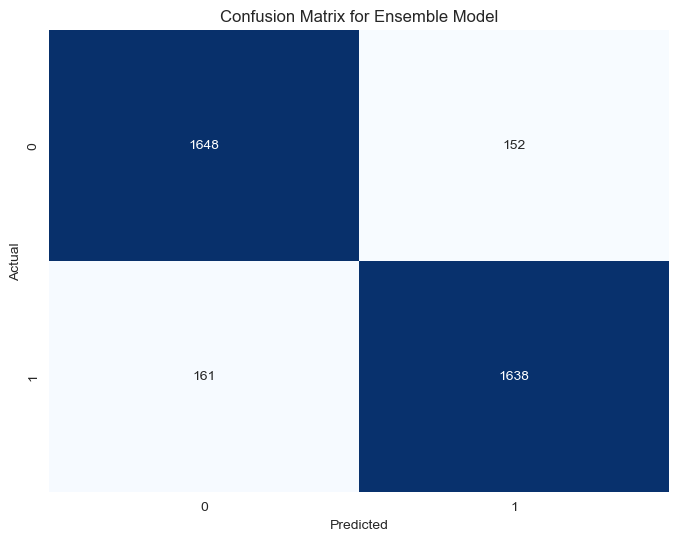

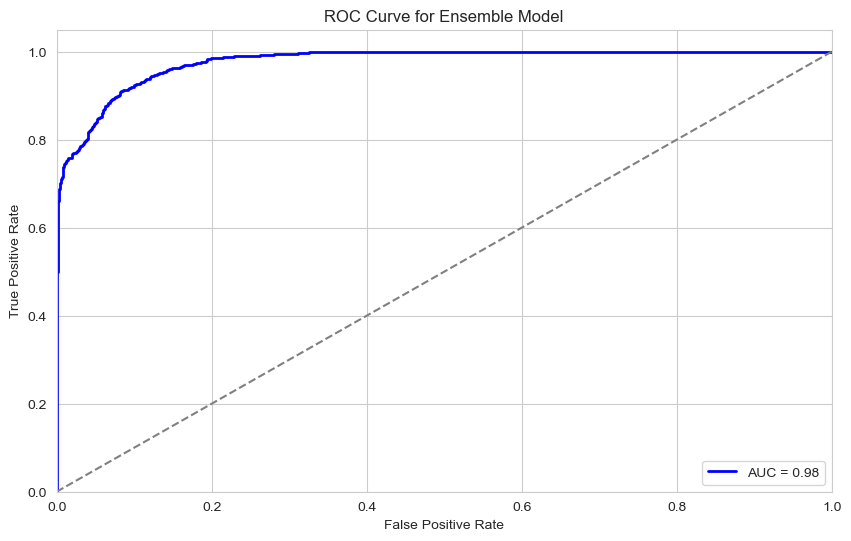

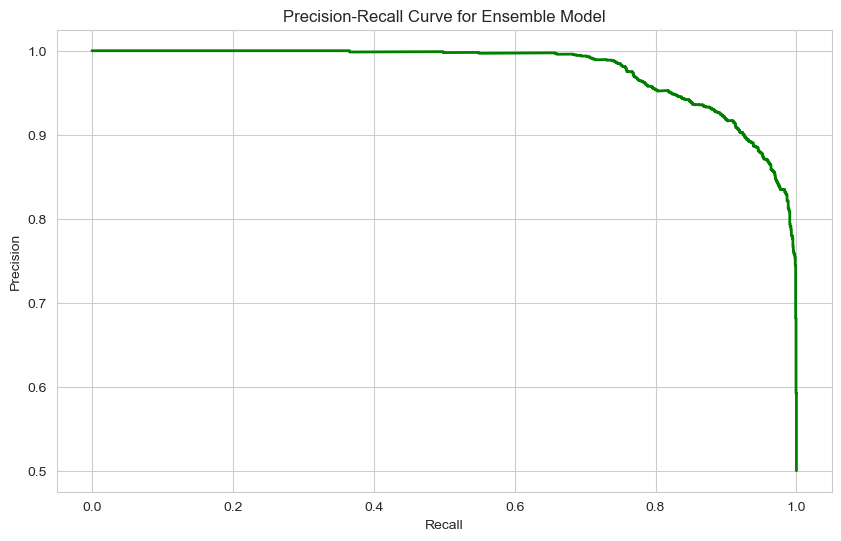

In [18]:
# Confusion Matrix Visualization for Adjusted Predictions
cm = confusion_matrix(y_test_encoded, y_pred_adjusted)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve (AUC remains threshold-independent)
fpr, tpr, _ = roc_curve(y_test_encoded, y_prob_ensemble)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve for Ensemble Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_encoded, y_prob_ensemble)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.title('Precision-Recall Curve for Ensemble Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

## Individual Model Evaluation & Performance Metrics Computation

<Figure size 1200x700 with 0 Axes>

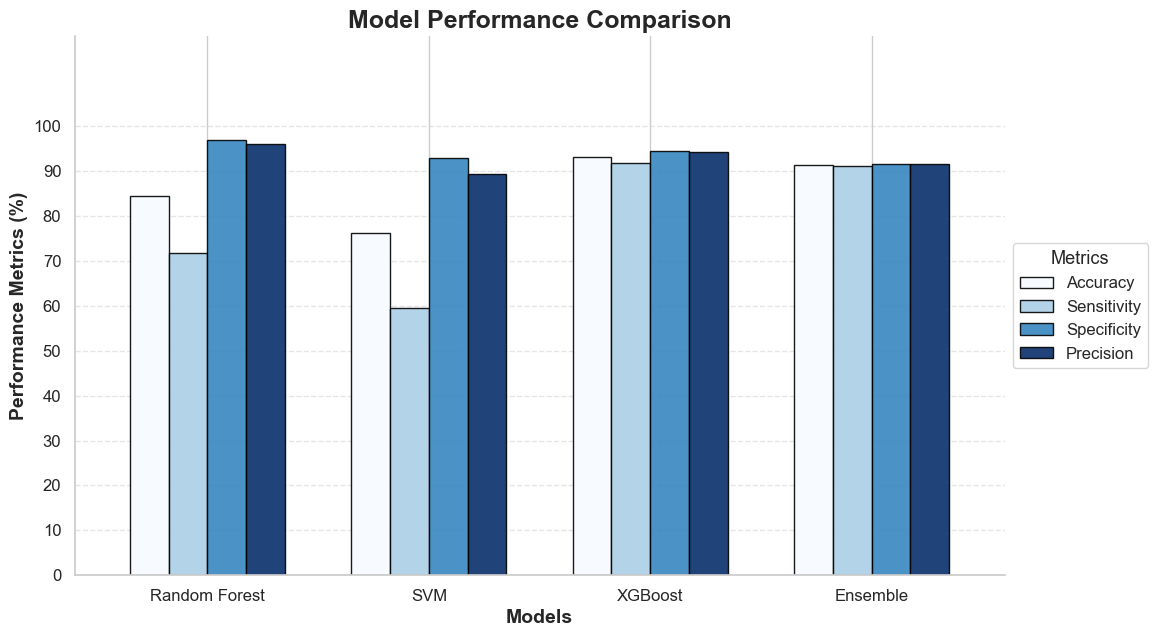

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

rf_model.fit(X_train, y_train_encoded)
svm_model.fit(X_train, y_train_encoded)
xgb_model.fit(X_train, y_train_encoded)

rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
ensemble_predictions = y_pred_adjusted

def calculate_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    return [accuracy, sensitivity, specificity, precision]

metrics_dict = {
    "Random Forest": calculate_metrics(y_test_encoded, rf_predictions),
    "SVM": calculate_metrics(y_test_encoded, svm_predictions),
    "XGBoost": calculate_metrics(y_test_encoded, xgb_predictions),
    "Ensemble": calculate_metrics(y_test_encoded, ensemble_predictions)
}

metrics_df = pd.DataFrame(metrics_dict, index=["Accuracy", "Sensitivity", "Specificity", "Precision"]).T
sns.set_theme(style="whitegrid")
metrics_df_percentage = metrics_df * 100

plt.figure(figsize=(12, 7))
ax = metrics_df_percentage.plot(kind='bar', figsize=(12, 7), colormap='Blues', edgecolor='black', alpha=0.9, width=0.7)
plt.title("Model Performance Comparison", fontsize=18, fontweight='bold', loc='center')
plt.ylabel("Performance Metrics (%)", fontsize=14, fontweight='bold')
plt.xlabel("Models", fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=12)
plt.yticks(np.arange(0, 110, 10), fontsize=12)
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Metrics", fontsize=12, title_fontsize=13, loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()
plt.show()